In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

In [2]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.utils import algorithm_globals
from qiskit.algorithms.minimum_eigensolvers import QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler

from qiskit_optimization.applications import VehicleRouting


distance
 [[ 0. 64. 46. 31.]
 [64.  0. 76. 94.]
 [46. 76.  0. 49.]
 [31. 94. 49.  0.]]


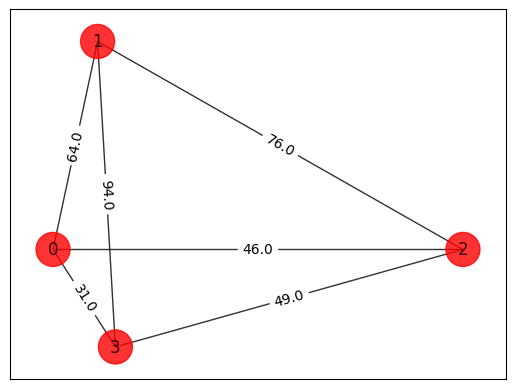

In [3]:
# Generating a graph of 3 nodes
n = 4
num_qubits = n**2
vrp = VehicleRouting.create_random_instance(n, low=0, high=100, seed=123, num_vehicle=2, depot=0)
adj_matrix = nx.to_numpy_array(vrp.graph)
print("distance\n", adj_matrix)

colors = ["r" for node in vrp.graph.nodes]
pos = [vrp.graph.nodes[node]["pos"] for node in vrp.graph.nodes]

def draw_graph(G, colors, pos):
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)

draw_graph(vrp.graph, colors, pos)

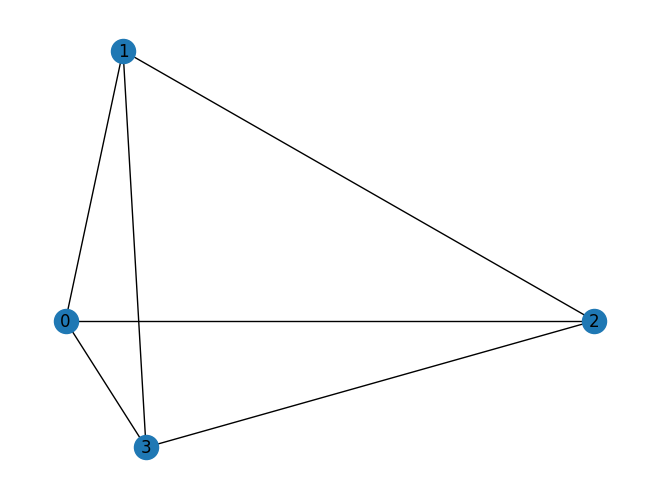

In [4]:
prob = VehicleRouting(vrp.graph, num_vehicles=2, depot=0)
prob.draw(pos=pos)

In [5]:
qp = prob.to_quadratic_program()
print(qp.prettyprint())

Problem name: Vehicle routing

Minimize
  64*x_0_1 + 46*x_0_2 + 31*x_0_3 + 64*x_1_0 + 76*x_1_2 + 94*x_1_3 + 46*x_2_0
  + 76*x_2_1 + 49*x_2_3 + 31*x_3_0 + 94*x_3_1 + 49*x_3_2

Subject to
  Linear constraints (12)
    x_1_0 + x_1_2 + x_1_3 == 1  'c0'
    x_2_0 + x_2_1 + x_2_3 == 1  'c1'
    x_3_0 + x_3_1 + x_3_2 == 1  'c2'
    x_0_1 + x_2_1 + x_3_1 == 1  'c3'
    x_0_2 + x_1_2 + x_3_2 == 1  'c4'
    x_0_3 + x_1_3 + x_2_3 == 1  'c5'
    x_1_0 + x_2_0 + x_3_0 == 2  'c6'
    x_0_1 + x_0_2 + x_0_3 == 2  'c7'
    x_1_2 + x_2_1 <= 1  'c8'
    x_1_3 + x_3_1 <= 1  'c9'
    x_2_3 + x_3_2 <= 1  'c10'
    x_1_2 + x_1_3 + x_2_1 + x_2_3 + x_3_1 + x_3_2 <= 2  'c11'

  Binary variables (12)
    x_0_1 x_0_2 x_0_3 x_1_0 x_1_2 x_1_3 x_2_0 x_2_1 x_2_3 x_3_0 x_3_1 x_3_2



objective function value: 248.0
variable values: x_0_1=1.0, x_0_2=0.0, x_0_3=1.0, x_1_0=0.0, x_1_2=1.0, x_1_3=0.0, x_2_0=1.0, x_2_1=0.0, x_2_3=0.0, x_3_0=1.0, x_3_1=0.0, x_3_2=0.0
status: SUCCESS

solution: [[[0, 1], [1, 2], [2, 0]], [[0, 3], [3, 0]]]


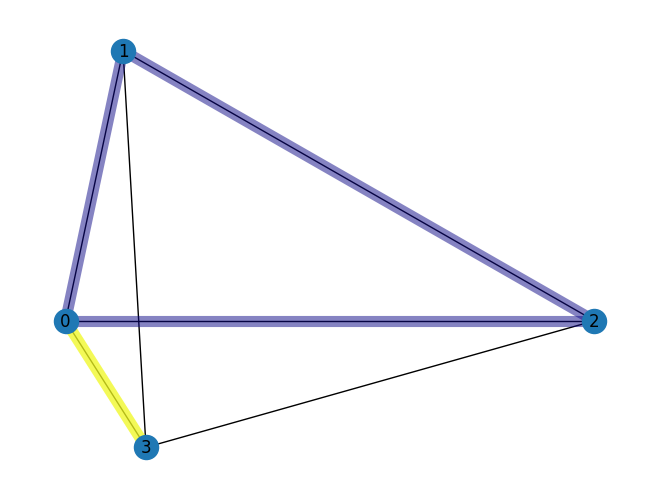

In [6]:
# Numpy Eigensolver
meo = MinimumEigenOptimizer(min_eigen_solver=NumPyMinimumEigensolver())
result = meo.solve(qp)
print(result.prettyprint())
print("\nsolution:", prob.interpret(result))
prob.draw(result, pos=pos)

In [ ]:
# QAOA
meo = MinimumEigenOptimizer(min_eigen_solver=QAOA(reps=1, sampler=Sampler(), optimizer=COBYLA()))
result = meo.solve(qp)
print(result.prettyprint())
print("\nsolution:", prob.interpret(result))
print("\ntime:", result.min_eigen_solver_result.optimizer_time)
prob.draw(result, pos=pos)